In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import sys
import os
import re

from tqdm import tqdm

In [ ]:
sys.path.append('./FNN')
from FNN_1 import FNN, CachedBERTDataset
from FNN_1_GPU import FNNGPU

# **Assign Data**

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/zzeiidann/Data/refs/heads/main/filtered_reviews_1_2_5.csv')
data

,overall,reviewText
0,5.0,It's good for beginners
1,5.0,I recommend this starter Ukulele kit. I has e...
2,5.0,G'daughter received this for Christmas present...
3,1.0,Please pay attention better than I did to the ...
4,5.0,"thanx, b"
...,...,...
176574,5.0,ok
176575,5.0,It's pretty great.
176576,5.0,Good inexpensive wiring harness. It will do th...
176577,1.0,The description stated they were full size pot...


In [ ]:
data['overall'] = data['overall'].apply(lambda x: 0 if x < 5 else 1)
data.rename(columns={'overall': 'sentiment'}, inplace=True)
data

,sentiment,reviewText
0,1,It's good for beginners
1,1,I recommend this starter Ukulele kit. I has e...
2,1,G'daughter received this for Christmas present...
3,0,Please pay attention better than I did to the ...
4,1,"thanx, b"
...,...,...
176574,1,ok
176575,1,It's pretty great.
176576,1,Good inexpensive wiring harness. It will do th...
176577,0,The description stated they were full size pot...


In [ ]:
data['reviewText'] = data['reviewText'].astype(str)
data['sentiment'] = data['sentiment'].astype(int)

Sentiment Distribution:
sentiment
1    161837
0     14742
Name: count, dtype: int64


<ipython-input-7-0821ac2635ec>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
<ipython-input-7-0821ac2635ec>:11: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.countplot(


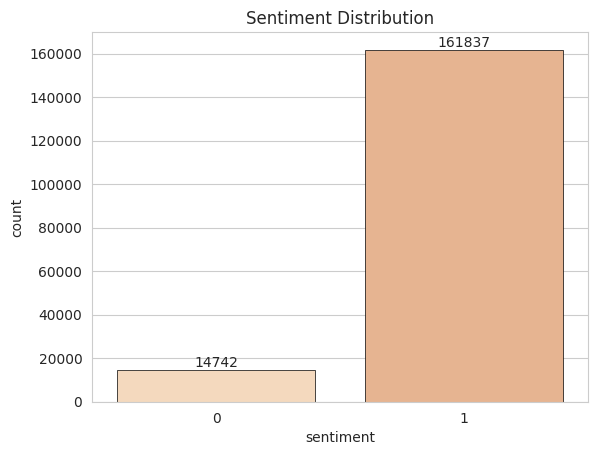

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Warna dari gambar (gradasi oranye)
custom_palette = ['#FDD9B5', '#F4B183', '#F29E63', '#F37A30']

sns.set_style('whitegrid')
print('Sentiment Distribution:')
print(data['sentiment'].value_counts())

ax = sns.countplot(
    x='sentiment',
    data=data,
    palette=custom_palette,
    linewidth=0.5,
    edgecolor='black'
)
plt.title('Sentiment Distribution')

# Tambahkan jumlah di atas setiap bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,  # atur offset di atas bar
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()


# **Preprocessing**

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = remove_emojis(text)
    text = re.sub(r'[^\w\s,.!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_data = [clean_text(contents) for contents in tqdm(data['reviewText'], desc="Cleaning Text")]
data['reviewText'] = cleaned_data

Cleaning Text: 100%|██████████| 176579/176579 [00:06<00:00, 27319.50it/s]


In [ ]:
data = pd.concat([
    data[data['sentiment'] != 1].sample(n=300, random_state=42),
    data[data['sentiment'] == 1].sample(n=300, random_state=42)
]).reset_index(drop=True)

<ipython-input-10-0821ac2635ec>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
<ipython-input-10-0821ac2635ec>:11: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.countplot(


Sentiment Distribution:
sentiment
0    300
1    300
Name: count, dtype: int64


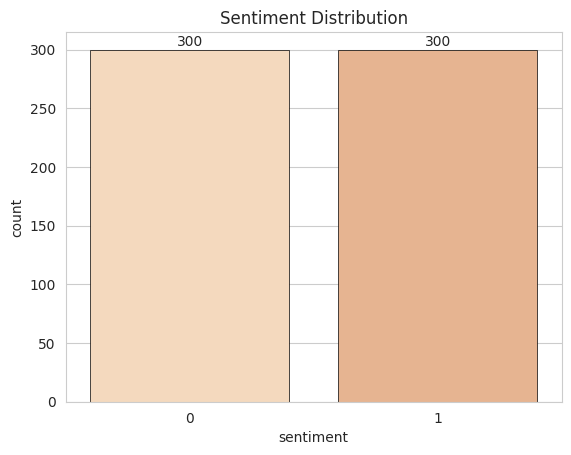

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Warna dari gambar (gradasi oranye)
custom_palette = ['#FDD9B5', '#F4B183', '#F29E63', '#F37A30']

sns.set_style('whitegrid')
print('Sentiment Distribution:')
print(data['sentiment'].value_counts())

ax = sns.countplot(
    x='sentiment',
    data=data,
    palette=custom_palette,
    linewidth=0.5,
    edgecolor='black'
)
plt.title('Sentiment Distribution')

# Tambahkan jumlah di atas setiap bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,  # atur offset di atas bar
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()


In [ ]:
print('Sentiment Distribution:')
print(data['sentiment'].value_counts())

Sentiment Distribution:
sentiment
0    300
1    300
Name: count, dtype: int64


# **Training Model**

In [ ]:
from sklearn.model_selection import train_test_split

data, val = train_test_split(data, test_size=0.03, random_state=42)

In [ ]:
data = data.reset_index(drop=True)
val = val.reset_index(drop=True)

In [ ]:
texts = data['reviewText']
labels = data['sentiment']

In [ ]:
dataset = CachedBERTDataset(texts, labels, bert_model='bert-base-uncased')

Loading BERT model: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model = FNNGPU(dims=[768, 500, 500, 2000, 32], n_clusters=7)

In [ ]:
import time
from keras.optimizers import SGD

start_time = time.time()

model.pretrain_autoencoder(dataset, batch_size=128, epochs=200)
model.load_weights('pretrained_ae.weights.pth')

end_time = time.time()
print(f"Total waktu: {end_time - start_time:.2f} detik")

Pretraining autoencoder...
Created tensor dataset with shape: torch.Size([582, 768])


Epoch 200/200: 100%|██████████| 5/5 [00:00<00:00, 166.34it/s, loss=0.0477]


Saved weights to pretrained_ae.weights.pth
Autoencoder pretrained and weights saved to pretrained_ae.weights.pth
Loaded weights from pretrained_ae.weights.pth
Total waktu: 13.30 detik


In [ ]:
start_time = time.time()
model.clustering_with_sentiment(dataset, update_interval=40, maxiter=700, batch_size=64, plot_evolution=True)
end_time = time.time()
print(f"Total waktu: {end_time - start_time:.2f} detik")

Update interval 40
Created dataset with 582 samples, embedding shape: torch.Size([582, 768]), label shape: torch.Size([582])


Extracting features: 100%|██████████| 10/10 [00:00<00:00, 813.70it/s]


Class distribution: {np.float32(0.0): np.int64(288), np.float32(1.0): np.int64(294)}
Computed class weights: {np.float32(0.0): np.float64(1.0104166666666667), np.float32(1.0): np.float64(0.9897959183673469)}
Initializing cluster centers with k-means.
Saved cluster plot for epoch 0 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_0.png
Save interval 50


Updating distribution (iter 0): 100%|██████████| 10/10 [00:00<00:00, 46.41it/s]


Class negative accuracy: 0.43403
Class positive accuracy: 0.43197
Iter 0: Cluster Loss 0.00000, Sentiment Loss 0.00000, Acc_sentiment 0.43299; loss=0.00000


Updating distribution (iter 40): 100%|██████████| 10/10 [00:00<00:00, 738.08it/s]


Saved cluster plot for epoch 40 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_40.png
Class negative accuracy: 0.86111
Class positive accuracy: 0.85034
Iter 40: Cluster Loss 0.63659, Sentiment Loss 5.99629, Acc_sentiment 0.85567; loss=6.44191


Saved weights to ./results/fnnjst/FNN_model_50.weights.pth


Updating distribution (iter 80): 100%|██████████| 10/10 [00:00<00:00, 632.67it/s]


Saved cluster plot for epoch 80 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_80.png
Class negative accuracy: 0.875
Class positive accuracy: 0.90816
Iter 80: Cluster Loss 0.86047, Sentiment Loss 4.87926, Acc_sentiment 0.89175; loss=5.48159


Saved weights to ./results/fnnjst/FNN_model_100.weights.pth


Updating distribution (iter 120): 100%|██████████| 10/10 [00:00<00:00, 750.52it/s]


Saved cluster plot for epoch 120 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_120.png
Class negative accuracy: 0.93403
Class positive accuracy: 0.93878
Iter 120: Cluster Loss 1.18226, Sentiment Loss 4.53003, Acc_sentiment 0.93643; loss=5.35761


Saved weights to ./results/fnnjst/FNN_model_150.weights.pth


Updating distribution (iter 160): 100%|██████████| 10/10 [00:00<00:00, 621.17it/s]


Saved cluster plot for epoch 160 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_160.png
Class negative accuracy: 0.95139
Class positive accuracy: 0.96259
Iter 160: Cluster Loss 1.46086, Sentiment Loss 4.22132, Acc_sentiment 0.95704; loss=5.24392


Updating distribution (iter 200): 100%|██████████| 10/10 [00:00<00:00, 815.31it/s]


Saved cluster plot for epoch 200 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_200.png
Class negative accuracy: 0.97222
Class positive accuracy: 0.97619
Iter 200: Cluster Loss 1.62946, Sentiment Loss 3.96455, Acc_sentiment 0.97423; loss=5.10518


Saved weights to ./results/fnnjst/FNN_model_200.weights.pth


Updating distribution (iter 240): 100%|██████████| 10/10 [00:00<00:00, 599.27it/s]


Saved cluster plot for epoch 240 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_240.png
Class negative accuracy: 0.97917
Class positive accuracy: 0.9932
Iter 240: Cluster Loss 1.73061, Sentiment Loss 3.76173, Acc_sentiment 0.98625; loss=4.97315


Saved weights to ./results/fnnjst/FNN_model_250.weights.pth


Updating distribution (iter 280): 100%|██████████| 10/10 [00:00<00:00, 654.27it/s]


Saved cluster plot for epoch 280 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_280.png
Class negative accuracy: 0.98611
Class positive accuracy: 0.9932
Iter 280: Cluster Loss 1.78506, Sentiment Loss 3.61697, Acc_sentiment 0.98969; loss=4.86652


Saved weights to ./results/fnnjst/FNN_model_300.weights.pth


Updating distribution (iter 320): 100%|██████████| 10/10 [00:00<00:00, 758.64it/s]


Saved cluster plot for epoch 320 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_320.png
Class negative accuracy: 0.99306
Class positive accuracy: 0.9966
Iter 320: Cluster Loss 1.78117, Sentiment Loss 3.45847, Acc_sentiment 0.99485; loss=4.70529


Saved weights to ./results/fnnjst/FNN_model_350.weights.pth


Updating distribution (iter 360): 100%|██████████| 10/10 [00:00<00:00, 773.04it/s]


Saved cluster plot for epoch 360 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_360.png
Class negative accuracy: 0.99653
Class positive accuracy: 0.9966
Iter 360: Cluster Loss 1.81602, Sentiment Loss 3.44289, Acc_sentiment 0.99656; loss=4.71411


Updating distribution (iter 400): 100%|██████████| 10/10 [00:00<00:00, 624.09it/s]


Saved cluster plot for epoch 400 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_400.png
Class negative accuracy: 0.99653
Class positive accuracy: 1.0
Iter 400: Cluster Loss 1.77098, Sentiment Loss 3.41543, Acc_sentiment 0.99828; loss=4.65511


Saved weights to ./results/fnnjst/FNN_model_400.weights.pth


Updating distribution (iter 440): 100%|██████████| 10/10 [00:00<00:00, 805.53it/s]


Saved cluster plot for epoch 440 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_440.png
Class negative accuracy: 0.99653
Class positive accuracy: 0.97619
Iter 440: Cluster Loss 1.80142, Sentiment Loss 3.40426, Acc_sentiment 0.98625; loss=4.66525


Saved weights to ./results/fnnjst/FNN_model_450.weights.pth


Updating distribution (iter 480): 100%|██████████| 10/10 [00:00<00:00, 748.17it/s]


Saved cluster plot for epoch 480 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_480.png
Class negative accuracy: 0.99653
Class positive accuracy: 1.0
Iter 480: Cluster Loss 1.76884, Sentiment Loss 3.38704, Acc_sentiment 0.99828; loss=4.62523


Saved weights to ./results/fnnjst/FNN_model_500.weights.pth


Updating distribution (iter 520): 100%|██████████| 10/10 [00:00<00:00, 823.30it/s]


Saved cluster plot for epoch 520 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_520.png
Class negative accuracy: 0.99653
Class positive accuracy: 1.0
Iter 520: Cluster Loss 1.72047, Sentiment Loss 3.31677, Acc_sentiment 0.99828; loss=4.52110


Saved weights to ./results/fnnjst/FNN_model_550.weights.pth


Updating distribution (iter 560): 100%|██████████| 10/10 [00:00<00:00, 628.33it/s]


Saved cluster plot for epoch 560 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_560.png
Class negative accuracy: 0.99653
Class positive accuracy: 1.0
Iter 560: Cluster Loss 1.71817, Sentiment Loss 3.34358, Acc_sentiment 0.99828; loss=4.54630


Updating distribution (iter 600): 100%|██████████| 10/10 [00:00<00:00, 719.74it/s]


Saved cluster plot for epoch 600 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_600.png
Class negative accuracy: 0.99653
Class positive accuracy: 1.0
Iter 600: Cluster Loss 1.66657, Sentiment Loss 3.27341, Acc_sentiment 0.99828; loss=4.44001
delta_label 0.0 < tol 0.001
Reached tolerance threshold. Stopping training.
Saved cluster plot for epoch 600 to ./results/fnnjst/evolution_plots/cluster_evolution_epoch_600.png
Saved weights to ./results/fnnjst/FNN_model_final.weights.pth
Total waktu: 91.35 detik


# **Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import re
from tqdm.notebook import tqdm
def predict_sentiment(text, model):
    """
    Memprediksi sentimen dari teks menggunakan model yang diberikan.

    Args:
        text (str): Teks yang akan diprediksi
        model: Model sentimen yang akan digunakan

    Returns:
        str: Sentimen ('positive' atau 'negative')
    """
    result = model.predict(text, bert_model='bert-base-uncased')
    sentiment = result[0]['sentiment']
    return sentiment

def evaluate_sentiment_model(val_df, model):
    """
    Mengevaluasi model sentimen pada validation dataset.

    Args:
        val_df (pd.DataFrame): DataFrame validation dengan kolom 'reviewText' dan 'sentiment'
        model: Model sentimen yang akan dievaluasi

    Returns:
        dict: Dictionary dengan metrik evaluasi
    """
    label_mapping = {0: 'negative', 1: 'positive'}

    predicted_sentiments = []
    true_sentiments = []

    for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Evaluating sentiment"):
        review_text = row['reviewText']

        true_sentiment = label_mapping[row['sentiment']]
        predicted_sentiment = predict_sentiment(review_text, model)

        predicted_sentiments.append(predicted_sentiment)
        true_sentiments.append(true_sentiment)

    predicted_labels = [1 if sent == 'positive' else 0 for sent in predicted_sentiments]
    true_labels = [1 if sent == 'positive' else 0 for sent in true_sentiments]

    acc = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    metrics = {
        'accuracy': acc,
        'f1_score': f1
    }

    return metrics

# Evaluasi model
metrics = evaluate_sentiment_model(val, model)
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")

Evaluating sentiment:   0%|          | 0/18 [00:00<?, ?it/s]

Accuracy: 0.7778
F1-Score: 0.6667


In [ ]:
embeddings = []

for i in range(len(dataset)):
    item = dataset[i]
    if isinstance(item, tuple):
        embedding, _ = item
        embeddings.append(embedding.cpu().numpy())
    else:
        embeddings.append(item.cpu().numpy())

In [ ]:
x = np.array(embeddings)
x

array([[-0.2639542 , -0.44275263,  0.5544364 , ...,  0.32884592,
         0.0248142 , -0.16201669],
       [-0.2222034 ,  0.05037168, -0.20272934, ...,  0.2916596 ,
        -0.00672566,  0.6844956 ],
       [-0.24546583,  0.05712134,  0.2766635 , ..., -0.14511217,
         0.19976327,  0.21783525],
       ...,
       [-0.53334194,  0.15545651,  0.5541168 , ..., -0.47305584,
         0.37125474,  0.11857449],
       [-0.19527404,  0.44163194,  0.13310415, ..., -0.74577063,
         0.238492  ,  0.42779407],
       [-0.34549665, -0.12012731,  0.66319036, ..., -0.05436843,
         0.08499848,  0.3797766 ]], dtype=float32)

In [ ]:
model.set_stop_words(
    [
        # Standard English stopwords (subset dari nltk)
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
        "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
        'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
        'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
        'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
        'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
        'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
        'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
        'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
        'with', 'about', 'against', 'between', 'into', 'through', 'during',
        'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
        'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
        'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
        'than', 'too', 'very', 'can', 'will', 'just', 'don', "don't",
        'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
        'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
        'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
        "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
        "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
        "won't", 'wouldn', "wouldn't", 'one', 'ive', 'much', 'it.', 'well', 'better', 'guitar', 'sound'

        # Slang, typo, modern abbreviations
        'omg', 'lol', 'lmao', 'rofl', 'idk', 'idc', 'ikr', 'btw', 'tbh',
        'imo', 'imho', 'bruh', 'bro', 'sis', 'yo', 'ngl', 'smh', 'fyi',
        'atm', 'irl', 'afk', 'asap', 'bff', 'bffs', 'bday', 'tho', 'tho.',
        'cuz', 'coz', 'ya', 'yay', 'yup', 'nah', 'nope', 'yea', 'ok', 'okay',
        'plz', 'pls', 'uh', 'uhh', 'uhm', 'umm', 'hmm', 'haha', 'hehe',
        'huhu', 'aww', 'ugh', 'oof', 'wtf', 'wth', 'rip', 'xd', ':)', ':(',

        # App review specific
        'app', 'apps', 'application', 'apk', 'play', 'store', 'google',
        'account', 'login', 'sign', 'signup', 'signin', 'register',
        'install', 'uninstall', 'installed', 'uninstalled', 'device',
        'android', 'ios', 'phone', 'mobile', 'tablet', 'version',
        'update', 'crash', 'bug', 'fix', 'error', 'issue', 'problem',
        'slow', 'fast', 'lag', 'laggy', 'loading', 'load', 'performance',
        'feature', 'features', 'option', 'options', 'setting', 'settings',
        'ads', 'ad', 'advertisement', 'popup', 'banner', 'review',
        'rating', 'stars', 'dev', 'developer', 'team', 'support', 'help',
        'please', 'kindly', 'hope', 'wish', 'thanks', 'thank', 'love',
        'hate', 'like', 'dislike', 'amazing', 'awesome', 'great', 'good',
        'bad', 'worst', 'cool', 'nice', 'perfect', 'trash', 'useless',
        'sucks', 'wow', 'working', 'works', 'doesn’t', 'doesnt', 'won’t',
        'wont', 'can’t', 'cant', 'don’t', 'dont', 'would', 'could',
        'should',

        # Filler / stop words informal tambahan
        'literally', 'actually', 'basically', 'seriously', 'really',
        'totally', 'kinda', 'sorta', 'maybe', 'probably', 'definitely',
        'honestly', 'fr', 'legit', 'even', 'ever', 'always', 'never',
        'again', 'still', 'yet', 'already', 'also', 'tho', 'alr', 'let', 'bought', 'buy',
        'make', 'get', 'got', 'see', 'say', 'said', 'think', 'feel',
        'want', 'need', 'give', 'take', 'try', 'trying', 'keep', 'go', 'sounds',
        'went', 'back', 'come', 'came', 'sound', 'use', 'used', 'little', 'better', 'strings','two',
        'string', 'made', 'way'
    ]
)


cluster = model.analyze_clusters(x, texts)

In [ ]:
for i, row in cluster.iterrows():
    print(f"Cluster {row['Cluster']}")
    print(f"Common Words: {row['Common Words']}")
    print("=" * 150)


Cluster 0
Common Words: excellent (8), product (5), expected. (3), price. (3), sturdy (3), job (3), price! (2), great! (2), worked (2), best (2)
Cluster 1
Common Words: work (8), quality (5), guitar. (5), metal (5), easy (4), using (4), acoustic (4), chrome (4), pole (4), cable (3)
Cluster 2
Common Words: pedal (50), tone (32), power (32), thing (30), mic (26), amp (25), work (24), first (23), time (22), going (21)
Cluster 3
Common Words: didnt (21), work (9), amazon (7), something (7), cheap (7), time (6), couldnt (5), expect (5), right (5), work. (5)
Cluster 4
Common Words: time (8), work (7), product (7), stand (7), bridge (7), enough (6), item (6), brand (6), them. (6), strap (6)
Cluster 5
Common Words: set (8), best (7), strings. (6), first (5), daddario (5), time (4), acoustic (3), great. (3), tuning (3), gave (3)
Cluster 6
Common Words: using (14), pedal (14), first (12), bit (12), work (11), tried (11), thing (11), strap (11), lot (10), something (10)


In [ ]:
model.set_topic(0, "Penilaian Kualitas Umum & Nilai Pembelian")
model.set_topic(1, "Masalah Kesesuaian Produk & Harapan Pelanggan")
model.set_topic(2, "Keluhan Fungsi Pedal Pada Alat Musik")
model.set_topic(3, "KASODKOAS")

Assigned topic 'Penilaian Kualitas Umum & Nilai Pembelian' to cluster 0
Assigned topic 'Masalah Kesesuaian Produk & Harapan Pelanggan' to cluster 1
Assigned topic 'Keluhan Fungsi Pedal Pada Alat Musik' to cluster 2
Assigned topic 'KASODKOAS' to cluster 3


FNNGPU(
  (autoencoder): Autoencoder(
    (activation): ReLU()
    (encoder_layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=768, out_features=500, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=500, out_features=500, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=500, out_features=2000, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=2000, out_features=32, bias=True)
    )
    (decoder_layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=2000, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=2000, out_features=500, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=500, out_features=500, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=500, out_features=768, bias=True)
    )
  )
  (clustering): Clust

In [ ]:
model.predict("Idiot abis", bert_model='bert-base-uncased')

[{'sentiment': 'negative',
  'topic': 'Penilaian Kualitas Umum & Nilai Pembelian'}]

In [ ]:
data

,sentiment,reviewText
0,0,Already have two of these straps from other ve...
1,0,"Like many others, I have searched high and low..."
2,0,I messed around with this thing for several ho...
3,1,works good
4,1,Works perfectly.
...,...,...
577,0,Obviously cheap. Very stiff. Probably just use...
578,0,IT dose not work no sound at all the little re...
579,0,This stand has a chrome metal pole that goes i...
580,1,Pretty cool affordable pedal. Drum machine and...


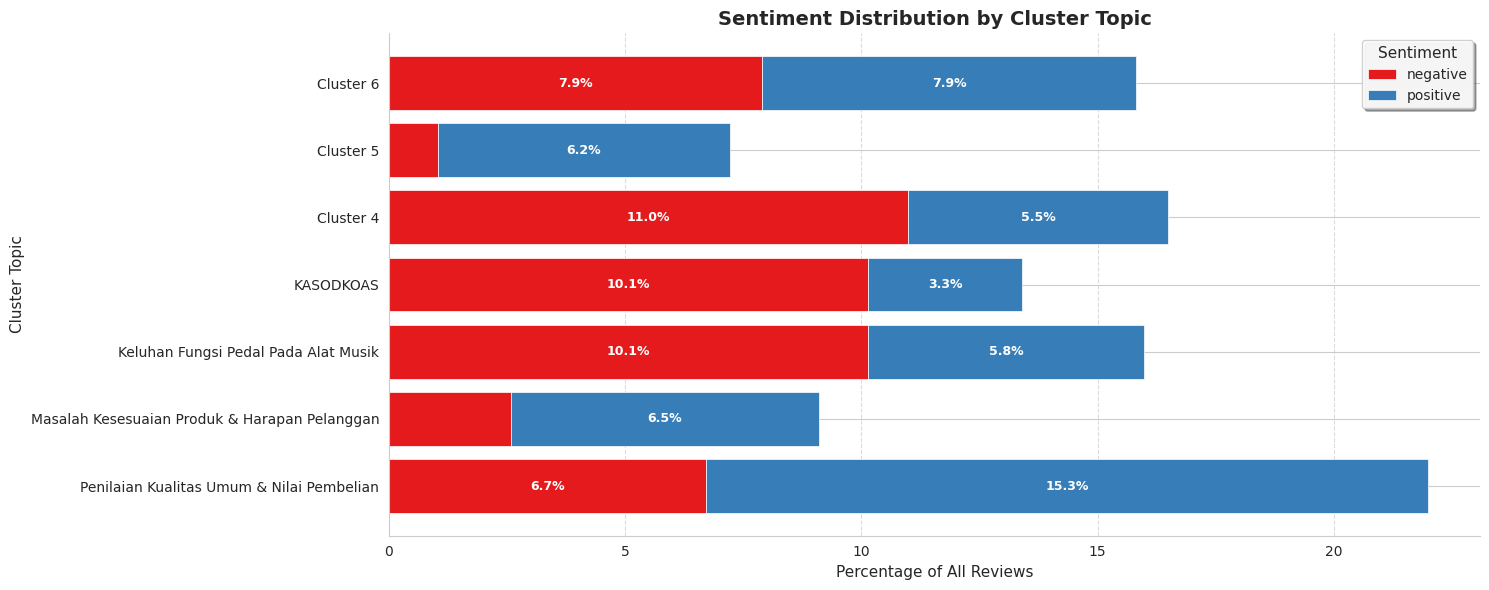

In [ ]:
fig = model.plot_sentiment_by_topic(data, x=x)
plt.show()

In [ ]:
data

,sentiment,reviewText
0,0,Already have two of these straps from other ve...
1,0,"Like many others, I have searched high and low..."
2,0,I messed around with this thing for several ho...
3,1,works good
4,1,Works perfectly.
...,...,...
577,0,Obviously cheap. Very stiff. Probably just use...
578,0,IT dose not work no sound at all the little re...
579,0,This stand has a chrome metal pole that goes i...
580,1,Pretty cool affordable pedal. Drum machine and...


In [ ]:
model.predict("pedal didnt, work", bert_model='bert-base-uncased')

[{'sentiment': 'negative', 'topic': 'KASODKOAS'}]

In [ ]:
def clean_interpret(data, x):
    new_data = data.copy()
    cluster = model.get_cluster_assignments(x)
    new_data['cluster'] = cluster
    return new_data

interpret = clean_interpret(data,x)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_count = interpret.groupby(['cluster', 'sentiment']).size().unstack(fill_value=0)
total_reviews = sentiment_count.values.sum()
sentiment_percent = (sentiment_count / total_reviews) * 100
cluster_topics = {
    0: "Penilaian Kualitas Umum & Nilai Pembelian",
    1: "Masalah Kesesuaian Produk & Harapan Pelanggan",
    2: "Keluhan Fungsi Pedal Pada Alat Musik",
    3: "Kemudahan Pemakaian & Pengaturan Awal"
}
sentiment_percent['topic'] = sentiment_percent.index.map(cluster_topics)

df_melted = sentiment_percent.reset_index().melt(
    id_vars=['cluster', 'topic'],
    value_vars=[0, 1],
    var_name='sentiment',
    value_name='percentage'
)

plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

bars = []
bottoms = [0] * 4

for sentiment_val, color in zip([0, 1], ["#333333", "#FF9900"]):
    data = df_melted[df_melted['sentiment'] == sentiment_val]
    bar = plt.barh(
        y=data['topic'],
        width=data['percentage'],
        left=bottoms,
        label='Negative' if sentiment_val == 0 else 'Positive',
        color=color
    )

    for i, (w, b) in enumerate(zip(data['percentage'], bottoms)):
        if w > 1:
            plt.text(b + w/2, i, f"{w:.1f}%", va='center', ha='center', color='white', fontsize=9, fontweight='bold')

    bottoms = [b + w for b, w in zip(bottoms, data['percentage'])]

plt.xlabel("Percentage of All Reviews")
plt.ylabel("Cluster Topic")
plt.title("Sentiment Distribution by Cluster (Stacked, Overall %)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [ ]:
!zip -r evolution_plots.zip /content/results/fnnjst/evolution_plots


  adding: content/results/fnnjst/evolution_plots/ (stored 0%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_160.png (deflated 5%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_0.png (deflated 4%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_280.png (deflated 4%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_560.png (deflated 4%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_440.png (deflated 4%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_480.png (deflated 4%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_320.png (deflated 5%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_400.png (deflated 4%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_520.png (deflated 5%)
  adding: content/results/fnnjst/evolution_plots/cluster_evolution_epoch_120.png (def